In [3]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [4]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [5]:
# imports
import pprint
import pickle
import glob
import random
from pathlib import Path
import math

import torch
from tqdm import tqdm
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from utils import utils
from utils import eval_utils
import deformation.losses as def_losses

In [6]:
# processing pose quality annotations
import xmltodict
pose_annotation_path = "notebooks/pix3d_chair_occnet_pose_quality_annotations.xml"
# processing xml from cvat
# https://github.com/openvinotoolkit/cvat
with open (pose_annotation_path, 'r') as f:
    f = f.read()
d = dict(xmltodict.parse(f))

pose_annotation_dict = {}
pose_quality_stats = {"num_good":0, "num_medium":0, "num_bad":0}
for entry in d['annotations']['image']:
    anno_dict = dict(entry)
    entry_label = dict(anno_dict['tag'])['@label']
    pose_annotation_dict[anno_dict['@name'].replace('.png', '')] = entry_label
    pose_quality_stats["num_{}".format(entry_label)] += 1
    
pprint.pprint(pose_quality_stats)


ModuleNotFoundError: No module named 'xmltodict'

In [ ]:
def filter_eval_df_by_quality(original_eval_df, pose_quality_dict, allowed_qualities=["good"]):
    instances_to_consider = [instance for instance in pose_quality_dict if pose_quality_dict[instance] in allowed_qualities]    
    filtered_df = original_eval_df[original_eval_df["instance"].isin(instances_to_consider)]
    return filtered_df

In [ ]:
#q = ["good", "medium","bad"]
#q = ["good", "medium"]
#q = ["good"]
#results_df = filter_eval_df_by_quality(results_df, pose_annotation_dict, allowed_qualities=q)

In [7]:
def compare_before_after_refinement(results_df_before, results_df_after):
    
    statistics = {"num_3d_iou_improved":0, "avg_improve_amt": 0, "avg_improve_before_2d_iou":0, "num_3d_iou_worse":0,  "avg_worse_amt":0, "avg_worse_before_2d_iou":0}
    improved_instances = []
    worse_instances = []
    comparision_df = pd.DataFrame()
    for instance in list(results_df_after["instance"]):
        if instance in list(results_df_before["instance"]):
            before_result = results_df_before[results_df_before["instance"]==instance]
            before_3d_iou = float(before_result["3d_iou"])
            #before_2d_iou = float(before_result["2d_iou"])
            after_result = results_df_after[results_df_after["instance"]==instance]
            after_3d_iou = float(after_result["3d_iou"])
            #after_2d_iou = float(after_result["2d_iou"])

            #iou_2d_change = after_2d_iou - before_2d_iou
            iou_3d_change = after_3d_iou - before_3d_iou

            if math.isnan(iou_3d_change):
                statistics["num_3d_iou_worse"] += 1
                continue
            elif iou_3d_change > 0:
                statistics["num_3d_iou_improved"] += 1
                statistics["avg_improve_amt"] += iou_3d_change
                #statistics["avg_improve_before_2d_iou"] += before_2d_iou
                improved_instances.append(instance)
            else:
                statistics["num_3d_iou_worse"] += 1
                statistics["avg_worse_amt"] += iou_3d_change
                #statistics["avg_worse_before_2d_iou"] += before_2d_iou
                worse_instances.append(instance)
            comparision_df = comparision_df.append({"instance": instance, "iou_3d_delta": iou_3d_change}, ignore_index=True)

    statistics["avg_improve_amt"] /= statistics["num_3d_iou_improved"]
    statistics["avg_improve_before_2d_iou"] /= statistics["num_3d_iou_improved"]
    statistics["avg_worse_amt"] /= statistics["num_3d_iou_worse"]
    statistics["avg_worse_before_2d_iou"] /= statistics["num_3d_iou_worse"]
            
    pprint.pprint(statistics)
    #print("example improved instances")
    #print(improved_instances[:100])
    #print("example worse instances")
    #print(worse_instances[:100])
    return comparision_df

In [8]:
def filter_eval_df_warnings(original_df, warnings_to_filter=["NaN nodes", "compute_iou_3d: gt mesh < 200 occupancies", "compute_iou_3d: rec mesh < 200 occupancies"]):
    filter_array = []
    warnings_list = original_df["eval_warnings"].tolist()
    for i in range(len(original_df)):
        warnings = warnings_list[i]
        keep=True
        for warning in warnings:
            if warning in warnings_to_filter:
                keep=False
        filter_array.append(keep)
    return original_df[filter_array]

def filter_and_sort_eval_dfs(df1, df2):
    df1 = filter_eval_df_warnings(df1)
    df2 = filter_eval_df_warnings(df2)
    df1_instances = df1["instance"].tolist()
    df2_instances = df2["instance"].tolist()
    
    df1_filters = [(True if df1_instance in df2_instances else False) for df1_instance in df1_instances]
    df1_filtered = df1[df1_filters].sort_values(by="instance")
    
    df2_filters = [(True if df2_instance in df1_instances else False) for df2_instance in df2_instances]
    df2_filtered = df2[df2_filters].sort_values(by="instance")
    
    return df1_filtered, df2_filtered

def update_2d_iou_input_to_bf(original_df, bf_2d_iou_df):
    if (original_df["instance"].tolist() != bf_2d_iou_df["instance"].tolist() ):
        raise ValueError("Instances don't match")
    original_df["2d_iou_input"] = bf_2d_iou_df["2d_iou_input"]
    return original_df
    

In [42]:
#class_ids = ["02691156", "02828884", "02933112", "02958343", "03001627", "03211117", "03636649", "03691459", "04090263", "04256520", "04379243", "04401088", "04530566"]
#class_ids = ["02691156", "02828884", "02933112", "03001627", "03211117", "03636649", "03691459", "04090263", "04256520", "04401088", "04530566"]
class_ids = ["02933112"]
#python evaluation.py /home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/02933112/generation/meshes --metrics 2d_iou_input --output_filename eval_results_bf_pose

In [44]:
pose_type = "bf"
for class_id in class_ids:
    print("------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    evaluation_dir_before = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_id)
    evaluation_dir_after = "data/pytorch3d_{}_{}_pose".format(class_id, pose_type)
    results_df_before_raw = pd.read_pickle(os.path.join(evaluation_dir_before, "eval_results.pkl"))
    results_df_after_raw = pd.read_pickle(os.path.join(evaluation_dir_after, "eval_results.pkl"))
    if pose_type == "bf":
        results_df_before_raw_bf = pd.read_pickle(os.path.join(evaluation_dir_before, "eval_results_bf_pose.pkl"))
        results_df_before_raw = update_2d_iou_input_to_bf(results_df_before_raw, results_df_before_raw_bf)

    results_df_before, results_df_after = filter_and_sort_eval_dfs(results_df_before_raw, results_df_after_raw)
    results_df_before["chamfer_L1"] = results_df_before["chamfer_L1"] * 10
    results_df_after["chamfer_L1"] = results_df_after["chamfer_L1"] * 10

    metrics = ["2d_iou_input", "2d_iou_multi", "3d_iou", "chamfer_L1"]
    delta_df = results_df_after[metrics].reset_index(drop=True) / results_df_before[metrics].reset_index(drop=True)
    delta_df = delta_df.replace([np.inf, -np.inf], np.nan)
    delta_df["3d_iou"] = delta_df["3d_iou"].apply(lambda x: (np.nan if x > 20 else x))
    #display(delta_df)
    #with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    #    display(delta_df.sort_values("chamfer_L1"))
    print("{} -> {}".format(evaluation_dir_before, evaluation_dir_after))
    print("Note: filtering results from {} to {}\n".format(max(len(results_df_before_raw), len(results_df_after_raw)), len(results_df_after)))
    #print(results_df_before.mean())
    #print("\n -> \n")
    #print(results_df_after.mean())
    print("\n Delta: \n")
    print((delta_df).mean(skipna=True))
    
    for metric in ["3d_iou", "2d_iou_multi"]:
        num_improved = len(delta_df[delta_df[metric]>1])
        avg_improve_amt = delta_df[delta_df[metric]>1][metric].mean()
        num_worse = len(delta_df[delta_df[metric]<1])
        avg_worse_amt = delta_df[delta_df[metric]<1][metric].mean()
        print("{} -- num improved: {} avg amount: {}".format(metric, num_improved, avg_improve_amt))
        print("{} -- num worse: {} avg amount: {}".format(metric, num_worse, avg_worse_amt))

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/02933112/generation/meshes -> data/pytorch3d_02933112_bf_pose
Note: filtering results from 190 to 185


 Delta: 

2d_iou_input    1.215097
2d_iou_multi    0.966686
3d_iou          0.963224
chamfer_L1      1.677842
dtype: float64
3d_iou -- num improved: 47 avg amount: 1.2512263651454982
3d_iou -- num worse: 138 avg amount: 0.8651361371976897
2d_iou_multi -- num improved: 62 avg amount: 1.0223306352730588
2d_iou_multi -- num worse: 123 avg amount: 0.9386374926954606


,2d_iou_input,2d_iou_multi,3d_iou,chamfer_L1
0,1.975243,0.815484,1.608230,1.181595
1,1.181669,1.025871,1.724641,0.416722
2,1.228916,1.061102,1.230691,0.677872
3,1.106557,0.995610,1.105675,0.989744
4,1.508282,0.955031,0.432736,1.488205
...,...,...,...,...
207,1.102462,1.005924,0.897272,0.918204
208,1.900759,0.865227,0.727176,3.683845
209,1.499369,0.824535,0.784320,1.860376
210,1.443181,0.860426,1.196103,1.761883


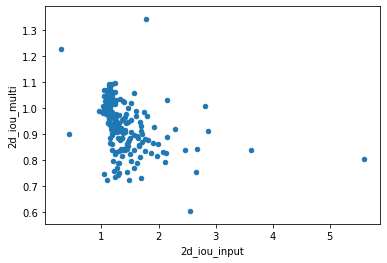

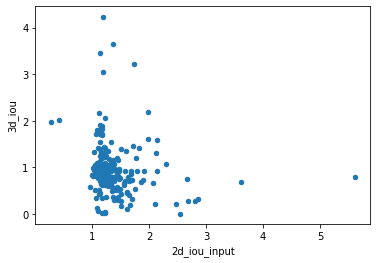

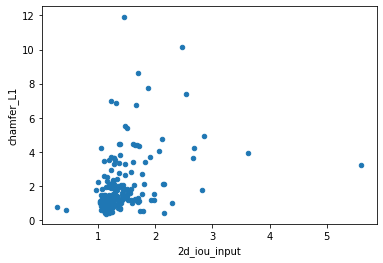

In [24]:
display(delta_df)
delta_df.plot.scatter(x="2d_iou_input", y="2d_iou_multi")
delta_df.plot.scatter(x="2d_iou_input", y="3d_iou")
delta_df.plot.scatter(x="2d_iou_input", y="chamfer_L1")

In [ ]:
#display(results_df_before)
iou_2d_delta_threshold = 0.17
filtered_delta_df = delta_df[delta_df["2d_iou_input"]<iou_2d_delta_threshold]
print((filtered_delta_df).mean())
print(len(filtered_delta_df))

{'avg_improve_amt': 0.055270607874723585,
 'avg_improve_before_2d_iou': 0.0,
 'avg_worse_amt': -0.10630149623603188,
 'avg_worse_before_2d_iou': 0.0,
 'num_3d_iou_improved': 79,
 'num_3d_iou_worse': 133}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feadd8f8be0>]],
      dtype=object)

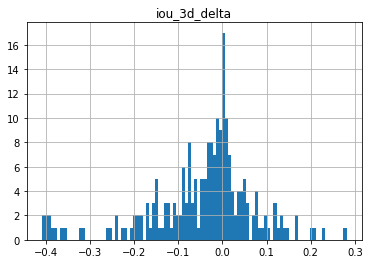

In [25]:
comp_df = compare_before_after_refinement(results_df_before, results_df_after)
comp_df.hist(column="iou_3d_delta", bins=100)